In [1]:
pip install pandas numpy scikit-learn matplotlib yfinance tensorflow scikeras

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasRegressor

In [3]:
# Download Apple stock data
data = yf.download("AAPL", start="2015-01-01", end="2023-01-01")

# Calculate moving averages and relative price change
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['Price_Change'] = data['Close'].pct_change()

# set target as next days close
data['Target'] = data['Close'].shift(-1)

# Drop rows with missing values
data.dropna(inplace=True)

#print(data.head())

[*********************100%***********************]  1 of 1 completed


In [4]:
#scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = data[['SMA_10', 'SMA_50', 'Price_Change']]
X_scaled = scaler_X.fit_transform(X)

y = data['Target']
y_scaled = scaler_y.fit_transform(y.to_frame())


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 1571, Testing samples: 393


In [5]:
#repeatable way to create the model 
def create_ann(neurons=32, activation='relu', optimizer='admin'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  #input structure
    model.add(Dense(neurons, activation=activation)) # hidden layer
    model.add(Dense(neurons, activation=activation)) # hidden layer
    model.add(Dense(1)) #output
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

<h1> GridSearch setup </h1>

In [11]:
# defone model parameters and create model
param_grid = {
    'model__neurons': [16, 32, 64, 128],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__optimizer': ['adam', 'sgd'],
    'batch_size': [16, 32],
    'epochs': [50, 100]
}

In [12]:
#training
model = KerasRegressor(model=create_ann, verbose=0) #keras regressor is a wrapper to us scikit learn gid search


# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,                       # cross-validation
    scoring='neg_mean_absolute_error',         # Use mse as scoring
    verbose=100,
    n_jobs=-1                   # Use all available cores
)

# Perform grid search on training data
grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)


Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\kenan\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [13]:
results_df = pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
for i, row in results_df.iterrows():
    print(f"Rank {row['rank_test_score']}:")
    print(f"Parameters: {row['params']}")
    print(f"Mean Test Score: {row['mean_test_score']:.4f}")
    print(f"Std Dev of Test Score: {row['std_test_score']:.4f}")
    print("-" * 30)

Rank 1:
Parameters: {'batch_size': 16, 'epochs': 100, 'model__activation': 'relu', 'model__neurons': 16, 'model__optimizer': 'adam'}
Mean Test Score: -0.0372
Std Dev of Test Score: 0.0013
------------------------------
Rank 2:
Parameters: {'batch_size': 16, 'epochs': 100, 'model__activation': 'tanh', 'model__neurons': 128, 'model__optimizer': 'sgd'}
Mean Test Score: -0.0375
Std Dev of Test Score: 0.0014
------------------------------
Rank 3:
Parameters: {'batch_size': 32, 'epochs': 100, 'model__activation': 'tanh', 'model__neurons': 16, 'model__optimizer': 'adam'}
Mean Test Score: -0.0379
Std Dev of Test Score: 0.0002
------------------------------
Rank 4:
Parameters: {'batch_size': 16, 'epochs': 100, 'model__activation': 'tanh', 'model__neurons': 64, 'model__optimizer': 'sgd'}
Mean Test Score: -0.0382
Std Dev of Test Score: 0.0023
------------------------------
Rank 5:
Parameters: {'batch_size': 32, 'epochs': 100, 'model__activation': 'tanh', 'model__neurons': 64, 'model__optimizer': 

Final Model MAE: 0.04081195385431317
Final Model RMSE: 0.06583292100508788


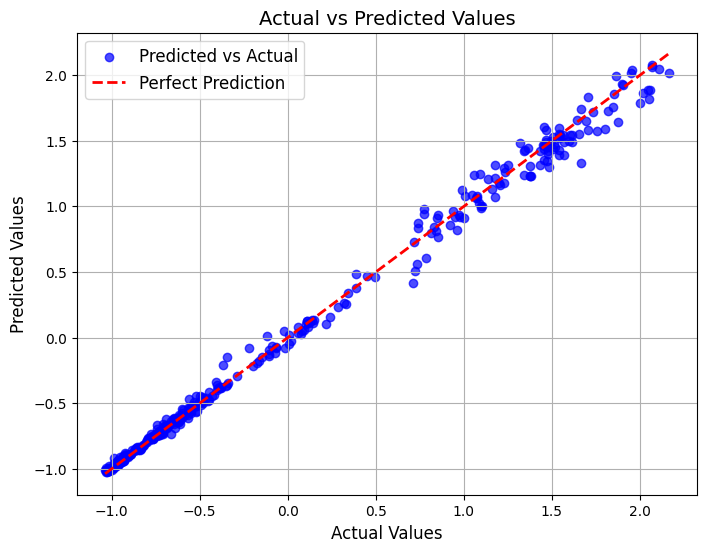

In [14]:
# use best model to predict
final_model = grid_search.best_estimator_

# Predict on test data
final_predictions = final_model.predict(X_test)

# Evaluate the final model
mae = mean_absolute_error(y_test, final_predictions)
mse = mean_squared_error(y_test, final_predictions)
rmse = np.sqrt(mse)

print(f"Final Model MAE: {mae}")
print(f"Final Model RMSE: {rmse}")

# Visualize Predictions vs. Actual Outcomes
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_predictions, alpha=0.7, color='b', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')  # Diagonal line
plt.title('Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed

Final Model MAE: 0.6370568022752225
Final Model RMSE: 0.7546428169045262


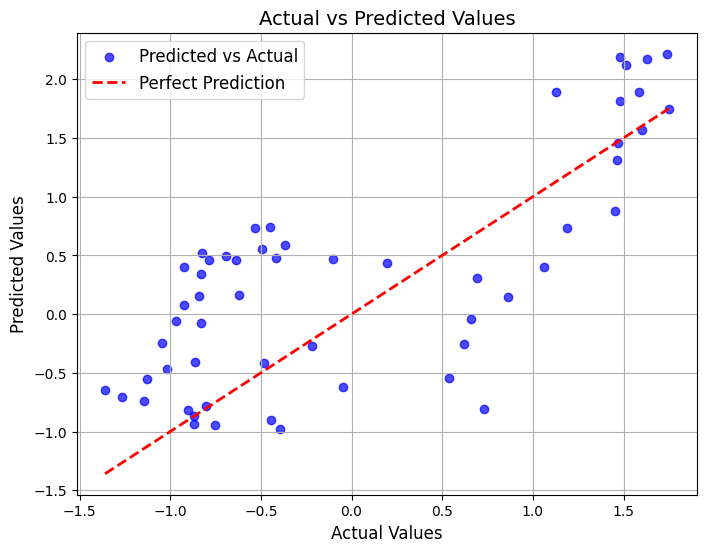

In [15]:
# trying to predict more recent ones
stock = yf.Ticker('AAPL')
data_to_predict = yf.download("AAPL", start="2024-01-01", end="2024-06-01")
data_to_predict['SMA_10'] = data_to_predict['Close'].rolling(window=10).mean()
data_to_predict['SMA_50'] = data_to_predict['Close'].rolling(window=50).mean()
data_to_predict['Price_Change'] = data_to_predict['Close'].pct_change()
data_to_predict['Target'] = data_to_predict['Close'].shift(-1)
data_to_predict.dropna(inplace=True)

X = data_to_predict[['SMA_10', 'SMA_50', 'Price_Change']]
Y = data_to_predict['Target']

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_y.fit_transform(Y.to_frame())

final_predictions = final_model.predict(X_scaled)

mae = mean_absolute_error(Y_scaled, final_predictions)
mse = mean_squared_error(Y_scaled, final_predictions)
rmse = np.sqrt(mse)

print(f"Final Model MAE: {mae}")
print(f"Final Model RMSE: {rmse}")

# Visualize Predictions vs. Actual Outcomes
plt.figure(figsize=(8, 6))
plt.scatter(Y_scaled, final_predictions, alpha=0.7, color='b', label='Predicted vs Actual')
plt.plot([Y_scaled.min(), Y_scaled.max()], [Y_scaled.min(), Y_scaled.max()], 'r--', lw=2, label='Perfect Prediction')  # Diagonal line
plt.title('Actual vs Predicted Values', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()